In [1]:

import os 
import pickle 
import evaluate_predictions
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import pstats
import re
import warnings

path_data = "../data/"
path_efficiencytest = f"{path_data}efficiency_test/"
path_profiling = f"{path_efficiencytest}profile/"
path_msmarco = f"{path_data}msmarco/"
name_aida_dataset = "aida_testB"

def filter_df(df, keep_strings, src):
    "Filter a dataframe with timings by function. Keep timings for functions with keep_strings."
    df = df.loc[df["fn"].str.contains(keep_strings), :].copy()
    df = df.loc[df['fn'] != "predict"] # predict calls with_coref, get_data_items, __predict
    df['src'] = src
    return df 


## Summary & issues
- Add lsh option to coref
    - min hashing with python/numpy 
    - integrate into REL and REBL
- run on aida and msmarco data 
- Results
    - AIDA: effectiveness is good, efficiency is not
    - Msmarco: process killed for lsh. unclear to me why.  
- Important issues
    - lsh: make it run, speed it up
    - ideas/wishes for alternative approaches to LSH? 

## Overview

### Changes to software
- add coref switch `search_corefs` to REL and REBL. 3 options
    - "off": do not search for coreferences
    - "all": for each mention, search all other mentions for a coreference
    - "lsh": find similar mentions with locality-sensitive hashing, currently implemented with MinHashing in python/numpy. After this, search for coreferences in the reduced set of comparison groups. 
- The main adjustment was done in `REL/src/REL/training_datasets.py`, and specifically in the function `with_coref`. The function is called unless `search_corefs="off"`. For the option `lsh`, the function uses the `LSHMinHash` class from the new module `lsh.py` in REL.
- `LSHMinHash` implements LSH with MinHashing. 
    - The key parameters are the shingle size, the resulting signature size, and the band length.
    - The shingle size defines the number of letters to be used for tokenization (?).
    - A vocabulary is defined based on all unique tokens. Each mention that gets a binary vector that indicates which of the shingles in the vocabulary are present in the mention.
    - The signature size defines how many times the binary vector are reshuffled and min hashes are generated (the position of the first 1 in the binary vector).
    - Mentions are then grouped together into buckets based on whether they share part of the signature. The band_lenght determines the length of the subsiganture to be generated and compared (and conversely also defines the number of subsignatures to be generated).
- I have assessed the performance of LSH with the coreference gold mentions in the aida data set.  
    - For band length 2, the best performance seems to be shingle size 4 and signature size of about 50 to 100.
    - Some more options should be tried out (longer band length)
- return indicator for whether a mention is identified as a coreference
- time ED for msmarco by document -- script separate from REBL 
- `evaluate_predictions`: add option whether only coreferences should be checked with function `find_coref`:
    - adapted from `__find_coref` in REL
    - mention cur_m is a coreference for mention m if 
        1. m contains cur_m as a word, besides other words. Ie, cur_m = "hendrix", m = "jimi hendrix"
        2. the gold entity of m and cur_m are the same (this is different from `__find_coref` where we do not have ground truth)


### Analysing efficiency and effectiveness
- Questions to be answered
    - Does `with_coref` impact the efficiency and effectiveness of REL? 
    - Given the time complexity of `with_coref`, does `with_coref` impact the efficiency differently for documents with more vs fewer mentions?
- Efficiency: large overhead from `__predict`,  the quadratic time complexity of `with_coref` starts to dominate the overal running time of entity disambiguation only for documents with 4000 mentions or more. This holds for both of the following two data sets:
    - AIDA: not a large number of mentions. $\rightarrow$ Create fake data for AIDA: stack the same mentions multiple times onto each other to generate a document with many mentions 
    - Use the msmarco data (tagged mentions from Chris)
- Effectiveness
    1. AIDA: Compare aggregate precision and recall when using `with_coref` and when not 
        - similar results independently of whether `with_coref` is used 
    2. AIDA: Compare precision and recall only for mentions that are coreferences
        - Find coreference mentions in the gold entities
        - Subset detected mentions to only coreferences 
        - *Result 1--comparing the coreference sample to the full sample of mentions*: REL performs worse at detecting mentions that are coreferences than mentions that are not. This is particularly the case for recall, which only 40 percent for coreferring mentions. The main reason for this is low recall in the mention detection part. A quick inspection indicates that many coreferences that use only last names are missed ("arafat" for "yasser arafat"). 
        - *Result 2--comparing within coreference sample when using `with_coref` and not*: precision and recall are lower when not using `with_coref` (2ppt and <1ppt, respectively)
    3. msmarco: no ground truth. For tagged mentions, compare predicted entities when using `with_coref` and when not using it. 
        - 60 percent of coreferring mentions are linked to a different entity when using `with_coref` versus when not using it. 
        - The results perhaps suggest that this difference gets larger with more mentions, but we do not have enough large documents to test this directly



### Main implications for REL
1. There may be a tradeoff efficiency-effectiveness for large number of mentions. Using a clustering algorithm for the coreferences could strike a balance
    - For small number of mentions, `with_coref` can be kept. Since this is known before the ED step, `with_coref` can be switched on and off depending on the document size 
    - What to do for large number of mentions? In some cases the user may ex-ante expect there to be many or few coreferences, and choose the option accordingly. But this is not a general solution. The clustering algorithm may help.
2. An important reason for low recall for coreferences is the mention detection, not the disambiguation, but coreferences are a small part of the total mentions in the training document. And some of this may be resolved with the update for MD from Erik.


### Next steps 
- LSH: make it work, speed up **--help needed**
    - currently breaks for msmarco after 3811 documents
    - it is too slow on the msmarco data 
- how and what to integrate from the changes mentioned mentioned above?
    - code review 
- what is the desired output format of the content in the present document? 


# 1. AIDA data 
## 1.1. Effectiveness: ED aggregate predictions with/without coref, across data sets 

Terminology
- 50 and 500 refer to the maximum number of documents from AIDA kept
- full sample refers to all detected mentions in a document. restricted sample refers to only mentions in a document that are identified as coreferences.

In [3]:
# load single data set 
files = os.listdir(f"{path_efficiencytest}/predictions")
coref_options = {
    "_all": "all",
    "_lsh": "lsh",
    "_off": "off"
}

files = [f for f in files if any(m in f for m in coref_options.keys())]
# files = [f for f in files if "_all|_off|_lsh" in f]
# files = sorted(files, key=lambda x: re.sub("_nocoref", "", x))
predictions = {}


for f in files:
    with open(f"{path_efficiencytest}/predictions/{f}", "rb") as file:
        f = re.sub(".pickle", "", f)
        predictions[f] = pickle.load(file)

In [3]:
for version, d in predictions.items():
    # this only works for the aida test data sets 
    if "aida_test" in version:
        print(f"Evaluating predictions for {version} (precision, recall, f1) for MD | EL")
        evaluate_predictions.evaluate(d["predictions"])
    


Evaluating predictions for aida_testB_500_off (precision, recall, f1) for MD | EL
Results: PMD RMD FMD PEL REL FEL: 97.9% 62.9% 76.6% | 62.1% 39.9% 48.6%
Evaluating predictions for aida_testB_500_all (precision, recall, f1) for MD | EL
Results: PMD RMD FMD PEL REL FEL: 97.9% 62.9% 76.6% | 62.1% 39.9% 48.6%
Evaluating predictions for aida_testB_500_lsh (precision, recall, f1) for MD | EL
Results: PMD RMD FMD PEL REL FEL: 97.9% 62.9% 76.6% | 62.0% 39.8% 48.5%
Evaluating predictions for aida_testB_50_lsh (precision, recall, f1) for MD | EL
Results: PMD RMD FMD PEL REL FEL: 97.4% 61.8% 75.7% | 65.8% 41.7% 51.1%
Evaluating predictions for aida_testB_50_off (precision, recall, f1) for MD | EL
Results: PMD RMD FMD PEL REL FEL: 97.4% 61.9% 75.7% | 65.7% 41.7% 51.0%
Evaluating predictions for aida_testB_50_all (precision, recall, f1) for MD | EL
Results: PMD RMD FMD PEL REL FEL: 97.4% 61.8% 75.7% | 65.8% 41.7% 51.1%


## 1.2. Effectiveness: ED predictions with/without coref for only coreferring mentions

**Approach**
- When running ED `with_coref`, label the identified mentions whether they are a coreference or not 
- For both predictions with and without coref, subset the predicted entities only to those mentions that were identified as coreferences.
- The gold entities also need to be adjusted
    - If we drop mentions that are not coreferences from our predictions, recall will mechanically decrease. And substantially so, because many mentions are not coreferences
    - Therefore, also identify coreferences in the gold data: same definition as for the input data plus the mentions refer to the same entity

In [4]:
n_documents = [50, 500] 
predictions_for_coreferences = {}

for n in n_documents:
    base_name = f"{name_aida_dataset}_{n}" 
    iteration_names = [f"{base_name}{suffix}" for suffix in coref_options.keys()]
    # extract predictions for the current n
    subset_predictions = {f"{name}": predictions[f"{base_name}{suffix}"]['predictions'] for suffix, name in coref_options.items()}
    docnames = list(subset_predictions['all'].keys())
    predicted_entities = {}
    for docname in docnames:
        temp_mentions = {k: v[docname] for k, v in subset_predictions.items()}
        # take as coreferences those that are recognized as such with option "all"
        all_mentions = temp_mentions["all"]
        n_mentions = len(all_mentions)

        extracted_predictions = {k: [mentions[i] for i in range(n_mentions) if all_mentions[i]["is_coref"] == 1] for k, mentions in temp_mentions.items()}
        predicted_entities[docname] = extracted_predictions
    
    predictions_for_coreferences[n] = predicted_entities


In [5]:
# to evaluate, need to change the shape: 
    # dict with ns
        # dict with versions
            # docnames and predictions 

ns = predictions_for_coreferences.keys()

for n, preds in predictions_for_coreferences.items():
    print(f"\nPredictions for coreferences with {n} documents \n-----------------------------")
    # preds = predictions_for_coreferences[n]
    # first bring predictions into right format for evaluate_predictions (see above)
    docnames = preds.keys()
    predictions_reshaped = {k: {} for k in coref_options.values()} 
    for option in coref_options.values():
        for d in docnames:
            predictions_reshaped[option][d] = preds[d][option]
    
    for option, d in predictions_reshaped.items():
        print(f"coref option: {option}")
        _ = evaluate_predictions.evaluate(d, coref_only=True)




Predictions for coreferences with 50 documents 
-----------------------------
coref option: all
Results: PMD RMD FMD PEL REL FEL: 90.0% 38.2% 53.6% | 77.1% 32.7% 46.0%
coref option: lsh
Results: PMD RMD FMD PEL REL FEL: 90.0% 38.2% 53.6% | 77.1% 32.7% 46.0%
coref option: off
Results: PMD RMD FMD PEL REL FEL: 90.0% 38.4% 53.8% | 75.0% 32.0% 44.9%

Predictions for coreferences with 500 documents 
-----------------------------
coref option: all
Results: PMD RMD FMD PEL REL FEL: 90.7% 36.7% 52.3% | 78.8% 31.9% 45.4%
coref option: lsh
Results: PMD RMD FMD PEL REL FEL: 90.7% 36.9% 52.5% | 76.2% 31.0% 44.1%
coref option: off
Results: PMD RMD FMD PEL REL FEL: 90.7% 36.9% 52.5% | 76.8% 31.3% 44.4%


Notes
- Results for aida_testB_50 (full sample) refer to table 1 in Erik's document, row 2
    - the numbers exactly match 
- Comparing the full sample with the restricted sample (only coreferring mentions)
    1. Mention detection is much worse -- only about 40 percent of mentions that are coreferences are identified. In the full sample, 60 percent of all gold mentions are detected. This could be (1) because coreferences are harder to detect, or (2) because some detected mentions are not labelled as coreferences because the mention they are referring to is not detected. I think case (1) is more likely.
    2. Entity disambiguation: Precision is higher for coreferences than for the full sample. Recall is lower for coreferences than for the full sample. 
- Comparing effectiveness for coreferences when using `with_coref` and when not using it
    1. Whether `with_coref` or not is used not impact effectiveness a lot -- F1 scores are 1 percent point smaller when not using `with_coref` than when using it.
    2. These facts indicate that turning off `with_coref` on average only slightly worsen entity linking effectiveness.

## 1.3. Profiling: ED with/without coref, across data sets

In [4]:
files = os.listdir(path_profiling)
files = [f for f in files if any(m in f for m in coref_options.keys())]

predictions_profile = {}

for file in files:
    f = f"{path_profiling}{file}"
    d = pd.read_csv(f)
    file = re.sub(".csv", "", file)
    predictions_profile[file] = d



In [5]:
d_list = []
keep_strings = 'predict|with_coref'

for filename, d in predictions_profile.items():
    data = d.loc[d['fn'].str.contains(keep_strings), :].copy()
    data = data.loc[data['fn'] != 'predict', :]
    data['src'] = filename
    d_list.append(data)

df = pd.concat(d_list)


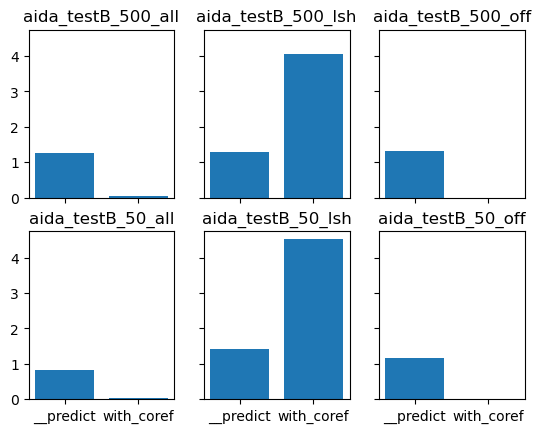

In [6]:
groups = df['src'].unique()
# groups = sorted(groups, key=lambda x: re.sub("_nocoref", "", x))
groups = sorted(groups)
n_cols = 3
n_rows = 2
idxs = [[x, y] for y in range(n_rows) for x in range(n_cols)]

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, sharey=True)

i = 0
for g in groups:
    dtemp = df.loc[df.src == g]
    col_idx = idxs[i][0]
    row_idx = idxs[i][1]
    x = dtemp['fn']
    y = dtemp['cumtime']
    axs[row_idx, col_idx].bar(x=x, height=y)
    axs[row_idx, col_idx].set_title(g)
    i += 1


## 1.4 Time complexity

Procedure
1. Create datasets with many more mentions by stacking the mentions from the same document multiple times 
2. Measure: total runtime of ED, profile ED for timing of `__predict` and `with_coref` for each document. See how timing changes with the number of mentions in a document.
3. Compare time complexity 


In [134]:
coref_options

{'_all': 'all', '_lsh': 'lsh', '_off': 'off'}

In [7]:
time_dataset = {}
path_mentions_time = f"{path_efficiencytest}n_mentions_time/"
for suffix, name in coref_options.items():
    with open(f"{path_mentions_time}{name_aida_dataset}{suffix}.pickle", "rb") as file:
        data = pickle.load(file)
        time_dataset[name] = data 


In [8]:

timing_overall = {}
for condition, conditiondata in time_dataset.items():
    d = []
    for docid, data in conditiondata.items():
        temp2 = {docid: {measure: value for measure, value in data.items() if measure in ["n_mentions", "time"]}}
        temp2 = pd.DataFrame.from_dict(temp2, orient="index")
        d.append(temp2)
    timing_overall[condition] = pd.concat(d)



In [12]:
timing_overall.keys()

dict_keys(['all', 'lsh', 'off'])

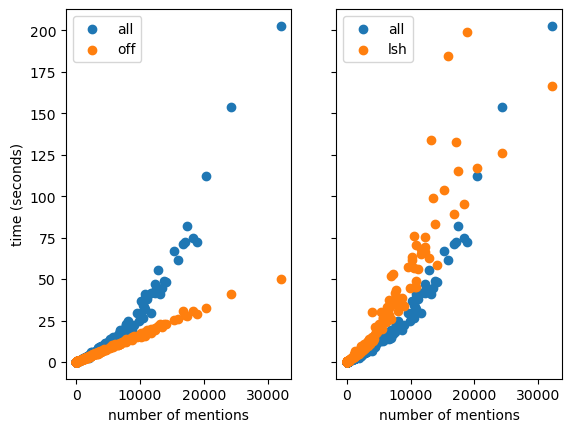

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

for lbl, d in timing_overall.items():
    if lbl in ["all", "off"]:
        x = d['n_mentions']
        y = d['time']
        axs[0].scatter(x=x, y=y, label=lbl)
    if lbl in ['all', 'lsh']:
        x = d['n_mentions']
        y = d['time']
        axs[1].scatter(x=x, y=y, label=lbl)


axs[0].set_ylabel("time (seconds)")
for a in axs:
    a.legend()
    a.set_xlabel("number of mentions")


# ax.legend()
# ax.set_xlabel("number of mentions")
# ax.set_ylabel("time (seconds)")
# ax.set_title("Measured time for ED with 'all' and 'off' ")

plt.savefig("figs/timing_aida_scale.pdf")

# fig, ax = plt.subplots()

# for lbl, d in timing_overall.items():
#     if lbl in ["all", "lsh"]:
#         x = d['n_mentions']
#         y = d['time']
#         ax.scatter(x=x, y=y, label=lbl)

# ax.legend()
# ax.set_xlabel("number of mentions")
# ax.set_ylabel("time (seconds)")
# ax.set_title("Measured time for ED with 'all' and 'lsh' ")

# plt.savefig("figs/timing_aida_scale.pdf")


In [10]:
timing_profile = []
for condition, conditiondata in time_dataset.items():
    print(condition)
    d = []
    for docid, data in conditiondata.items():
        d_profile = filter_df(data["profile"], keep_strings=keep_strings, src=filename)
        d_profile['n_mentions'] = data['n_mentions']
        d.append(d_profile)
    df_out = pd.concat(d)
    df_out['condition'] = condition
    timing_profile.append(df_out)
    
# do the same for the profiling output, process as above 
timing_profile = pd.concat(timing_profile)


all
lsh
off


In [13]:
timing_profile.head()

,file,line,fn,cc,ncalls,tottime,cumtime,callers,src,n_mentions,condition
112,/home/flavio/projects/rel20/REL/src/REL/entity...,527,__predict,1,1,0.000297,0.013742,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_500_all,39,all
168,/home/flavio/projects/rel20/REL/src/REL/traini...,115,with_coref,1,1,0.000027,0.000430,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_500_all,39,all
113,/home/flavio/projects/rel20/REL/src/REL/entity...,527,__predict,1,1,0.018513,0.173257,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_500_all,195,all
168,/home/flavio/projects/rel20/REL/src/REL/traini...,115,with_coref,1,1,0.000088,0.008156,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_500_all,195,all
113,/home/flavio/projects/rel20/REL/src/REL/entity...,527,__predict,1,1,0.044579,0.337504,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_500_all,390,all


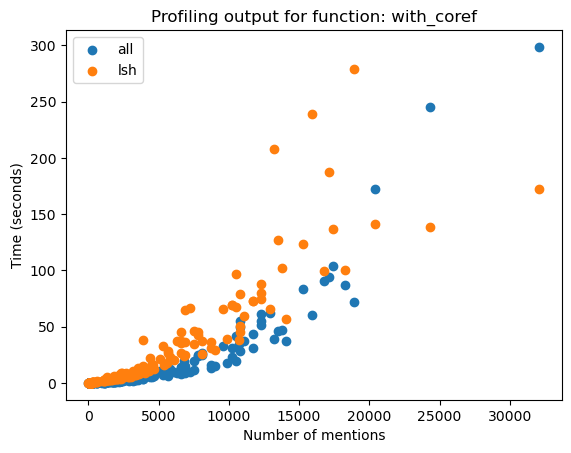

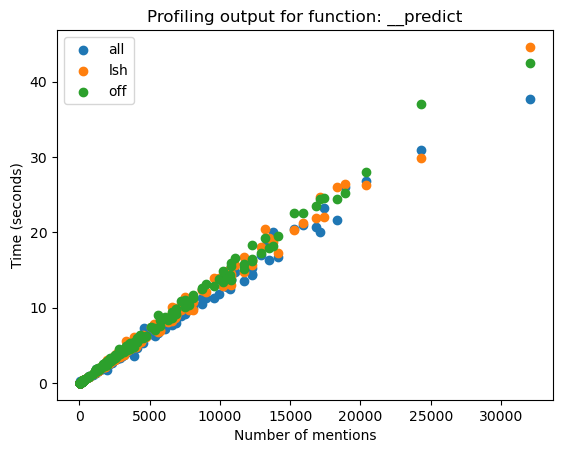

In [11]:

xlabel = 'Number of mentions'
ylabel = 'Time (seconds)'

for fnc in ['with_coref', '__predict']:
    fig, ax = plt.subplots()

    dtemp = timing_profile.loc[timing_profile['fn'] == fnc, :] # plot the timing for the function predict 
    conditions = dtemp['condition'].unique()

    for c in conditions:
        d = dtemp.loc[dtemp['condition'] == c, :]
        ax.scatter(x=d['n_mentions'], y=d['cumtime'], label=c)
        
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"Profiling output for function: {fnc}")
    if fnc == "with_coref":
        plt.savefig("figs/profile_aida_scale.pdf")



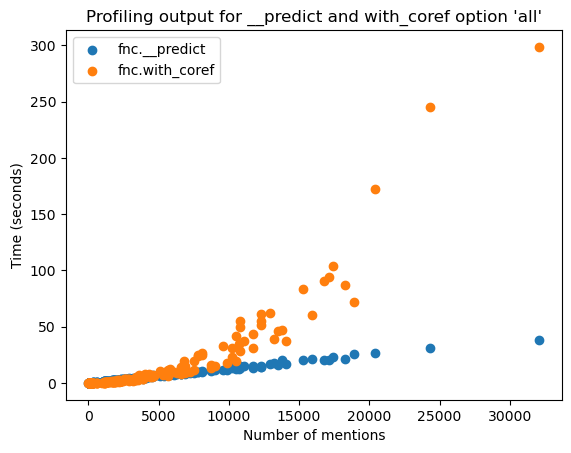

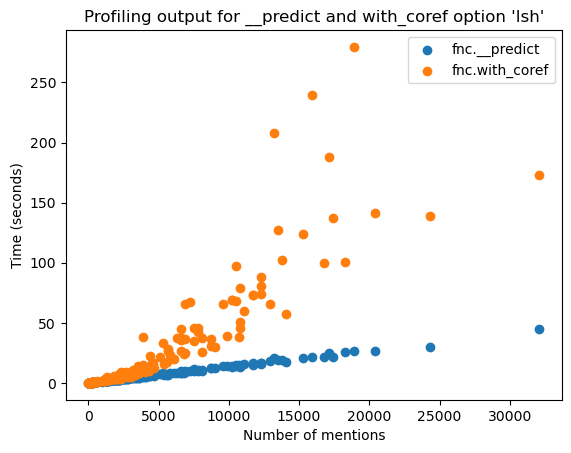

In [12]:
for opt in ['all', 'lsh']:
    fig, ax = plt.subplots()
    dtemp = timing_profile.loc[timing_profile['condition'] == opt, :]
    functions_to_plot = ['__predict', 'with_coref']

    for fn in functions_to_plot:
        fn_label = f"fnc.{fn}"
        d = dtemp.loc[dtemp['fn'] == fn, :]
        ax.scatter(x=d['n_mentions'], y=d['cumtime'], label=fn_label)


    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"Profiling output for __predict and with_coref option '{opt}'")

### Notes
- with_coref grows quadratically, that is expected 
- time for `__predict` does not depend on whether we use with_coref or not 
- the overhead of `__predict` is quite large (compared to the average number of mentions in the datasets I have looked at), only at around 4000 mentions the with_coref effects dominates 

# 2. MS Marco data

## 2.1. "Effectiveness": how much do predictions overlap?

- Run ED on the same file with detected mentions 
- Compare whether the linked entities are the same when using `with_coref` and when not using it

In [18]:
files_msmarco = ['ed_coref_off', 'ed_coref_all']  #'ed_coref_lsh'
idx_cols = ["doc_id", "field", "start_pos", "end_pos"]

d_msmarco = {f: pd.read_parquet(f"{path_msmarco}predictions/{f}.parquet") for f in files_msmarco}

if d_msmarco["ed_coref_all"].shape[0] != d_msmarco["ed_coref_off"].shape[0]:
    warnings.warn("Not the same number of entities in the two datasets")

# if d_msmarco["ed_coref_all"].shape[0] != d_msmarco["ed_coref_lsh"].shape[0]:
#     warnings.warn("Not the same number of entities in the two datasets")


for df in d_msmarco.values():
    df.drop(columns=['md_score', 'ed_score'], inplace=True)
    df.set_index(idx_cols, inplace=True)


/tmp/ipykernel_19240/4285697972.py:7: UserWarning: Not the same number of entities in the two datasets
  warnings.warn("Not the same number of entities in the two datasets")


a) Differences in which entities are linked -- approximates comparison of recall


In [35]:

name_main = "ed_coref_all"
all_only = d_msmarco["ed_coref_all"][~d_msmarco["ed_coref_all"].index.isin(d_msmarco["ed_coref_off"].index)].shape[0]
reference_all_only = d_msmarco["ed_coref_all"].loc[d_msmarco["ed_coref_all"]["is_coref"] == 1].shape[0]

print(f"Fraction of linked coreferring mentions in all that are not in off: {all_only/reference_all_only}")


Fraction of linked coreferring mentions in all that are not in off: 0.003650051328846812


b) Differences in how entities are linked -- approximates comparison of precision

In [6]:
colnames_to_change = ["entity", "ed_score", "tag"]

for name, df in d_msmarco.items():
    cols = df.columns 
    new_colnames = [f"{x}_{name}" if x in colnames_to_change else x for x in cols]
    d_msmarco[name].columns = new_colnames


In [7]:

d_compare = (d_msmarco["ed_coref_all"]
                .join(d_msmarco["ed_coref_off"].drop(columns="is_coref"))
                .reset_index()
            )

d_compare.head()
d_compare['same_entity'] = np.where(d_compare["entity_ed_coref_all"] == d_compare["entity_ed_coref_off"], 1, 0)
assert d_compare.shape[0] == d_msmarco["ed_coref_all"].shape[0], "not the same number of entities in d_compare and ed_coref"

print("Summary statistics across all mentions and all documents:")
d_compare.groupby("is_coref")["same_entity"].describe()

Summary statistics across all mentions and all documents:


,count,mean,std,min,25%,50%,75%,max
is_coref,,,,,,,,
0,247754.0,0.996791,0.056556,0.0,1.0,1.0,1.0,1.0
1,8767.0,0.402760,0.490481,0.0,0.0,0.0,1.0,1.0


In [8]:
xlabel = 'Total number of linked mentions in document'
ylabel = "Fraction same linked entity for options 'all' and 'off' "

plt_inputs = {
        "all": {
                "df": d_compare,
                "title": "All",
                "filename": "msmarco_overlap_all"
                },
        "coref_only": {
                "df": d_compare.loc[d_compare['is_coref']==1, :],
                "title": "Coreferring",
                "filename": "msmarco_overlap_corefs"
                },
        "no_coref": {
                "df": d_compare.loc[d_compare['is_coref']==0, :],
                "title": "Non-coreferring",
                "filename": "msmarco_overlap_nocorefs"
        }
}



Average overlap across documents (unweighted) for all: 0.903
Average overlap across documents (unweighted) for coref_only: 0.446
Average overlap across documents (unweighted) for no_coref: 0.988


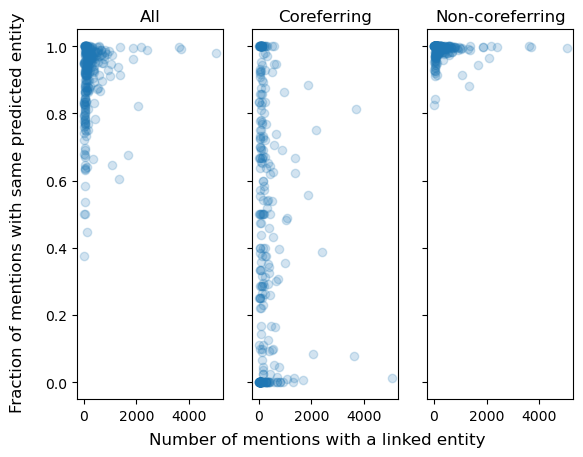

In [16]:
n_mentions_min = 5

d_size = d_compare.groupby(d_compare['doc_id']).size().to_frame('n_mentions')

d_coref = d_compare.loc[d_compare['is_coref'] == 1]
d_size_corefs = d_coref.groupby(d_coref['doc_id']).size().to_frame('n_mentions').reset_index()
d_size_corefs = d_size_corefs.loc[d_size_corefs['n_mentions'] > n_mentions_min]

fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)

idx = 0 
for sample, input in plt_inputs.items():
    df = input['df']
    # aggregate, join 
    d_agg = df.groupby(df['doc_id']).agg({"same_entity": "mean"})
    d_agg = d_agg.join(d_size).reset_index()

    # keep only docs with sufficient number of coreferring mentions 
    d_agg = d_agg.loc[d_agg["doc_id"].isin(d_size_corefs['doc_id'])]

    print(f"Average overlap across documents (unweighted) for {sample}: {round(d_agg.same_entity.mean(), 3)}")
    
    # plot 
    # fig, ax = plt.subplots()
    ax[idx].scatter(x=d_agg['n_mentions'], y=d_agg['same_entity'], alpha=0.2)
    # ax[idx].set_xlabel(xlabel)
    # ax[idx].set_ylabel(ylabel) 
    ax[idx].set_title(input['title'])
    idx += 1

    # fig.savefig(fname=f"figs/{input['filename']}.pdf")

fig.supxlabel("Number of mentions with a linked entity")
fig.supylabel("Fraction of mentions with same predicted entity")
fig.savefig(fname=f"figs/msmarco_overlap.pdf")

In [17]:

d_size = d_compare.groupby(d_compare['doc_id']).size().to_frame('n_mentions')

d_coref = d_compare.loc[d_compare['is_coref'] == 1]
d_size_corefs = d_coref.groupby(d_coref['doc_id']).size().to_frame('n_mentions').reset_index()
d_size_corefs = d_size_corefs.loc[d_size_corefs['n_mentions'] > n_mentions_min]

for sample, input in plt_inputs.items():
    df = input['df']
    # aggregate, join 
    d_agg = df.groupby(df['doc_id']).agg({"same_entity": "mean"})
    d_agg = d_agg.join(d_size).reset_index()

    # keep only docs with sufficient number of coreferring mentions 
    d_agg = d_agg.loc[d_agg["doc_id"].isin(d_size_corefs['doc_id'])]

    print(f"Average overlap across documents (unweighted) for {sample}: {round(d_agg.same_entity.mean(), 3)}")
    
    # plot 
    fig, ax = plt.subplots("Fraction of mentions with same predicted entity")
    ax.scatter(x=d_agg['n_mentions'], y=d_agg['same_entity'], alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel) 
    ax.set_title(input['title'])

    fig.savefig(fname=f"figs/{input['filename']}.pdf")


Average overlap across documents (unweighted) for all: 0.903


ValueError: Number of rows must be a positive integer, not 'Fraction of mentions with same predicted entity'

<Figure size 640x480 with 0 Axes>

## 2.2. Time complexity

In [22]:
n_docs = 5000 ## To be finished 
files = os.listdir(f"{path_msmarco}/timing/")
files = [f for f in files if str(n_docs) in f]

timing_msmarco = {}

for f in files:
    with open(f"{path_msmarco}/timing/{f}", "rb") as file:
        key = re.sub(f"_ndocs_{n_docs}.pickle", "", f)
        timing_msmarco[key] = pickle.load(file)

for key, data in timing_msmarco.items():
    df = pd.DataFrame.from_dict(data, orient="index").reset_index(names="docid")
    timing_msmarco[key] = df

In [23]:
files

['ed_coref_ndocs_5000_off.pickle', 'ed_coref_ndocs_5000_all.pickle']

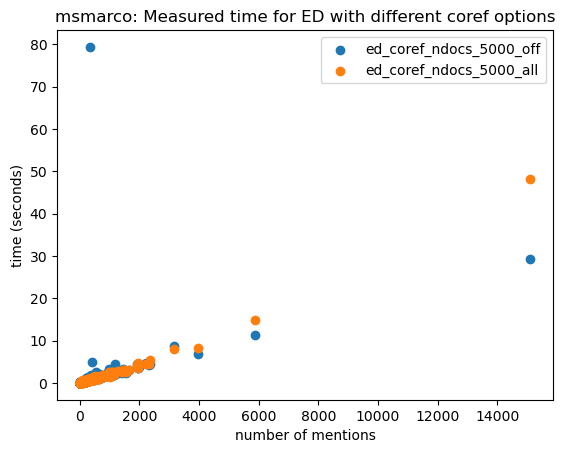

In [27]:
fig, ax = plt.subplots()

for lbl, d in timing_msmarco.items():
    x = d['n_mentions']
    y = d['timing_ed']
    lbl = re.sub(".pickle", "", lbl)
    ax.scatter(x=x, y=y, label=lbl)

ax.legend()
ax.set_xlabel("number of mentions")
ax.set_ylabel("time (seconds)")
ax.set_title("msmarco: Measured time for ED with different coref options")

fig.savefig(fname=f"figs/timing_msmarco.pdf")